# Input Tensor Exploration & Visualization

**ESM2 Contact Prediction - 68-Channel Input Analysis with Real Data**

This notebook provides exploration and visualization of the 68-channel input tensors used for training the CNN model.

## 🎯 Overview

- **68-Channel Architecture**: 4 template channels + 64 ESM2 embedding channels
- **Input Format**: (68, L, L) tensors where L = protein length
- **Data Source**: Real CNN dataset (1% of training data, ~118MB)
- **Goal**: Understand channel patterns and data quality

## 🚀 Real Data Pipeline

This notebook analyzes **100% real biological data**:
- ✅ **Real template features** from homology search
- ✅ **Real ESM2 embeddings** from Meta AI's language model
- ✅ **Real distance maps** from actual PDB structures


## 🔧 Setup and Data Loading

In [1]:
# Import required libraries
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display
import h5py
from typing import Dict, List, Tuple, Optional

# Add src to path for imports
sys.path.insert(0, str(Path().absolute().parent / "src"))

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

print("✅ Environment setup complete")

✅ Environment setup complete


## 📊 Data Configuration and Loading

In [2]:
# Data configuration
notebook_dir = Path().absolute()
project_root = notebook_dir.parent

# Dataset configuration
DATASET_PATH = project_root / "data" / "cnn_dataset.h5"
OUTPUT_DIR = notebook_dir / "tensor_analysis_output"
OUTPUT_DIR.mkdir(exist_ok=True)

# Global variables
cnn_data = None
protein_ids = []
protein_analyses = {}
hdf5_file = None

print("🔍 Loading CNN dataset...")

if DATASET_PATH.exists():
    try:
        hdf5_file = h5py.File(DATASET_PATH, 'r')
        
        if 'cnn_data' in hdf5_file:
            cnn_data = hdf5_file['cnn_data']
            protein_ids = list(cnn_data.keys())
            
            print(f"✅ Dataset loaded: {len(protein_ids)} proteins")
            print(f"   Sample proteins: {protein_ids[:5]}")
            
            # Load sample proteins for analysis
            sample_proteins = protein_ids[:3]
            
            for protein_id in sample_proteins:
                protein_group = cnn_data[protein_id]
                analysis = {}
                
                if 'multi_channel_input' in protein_group:
                    input_data = protein_group['multi_channel_input'][:]
                    analysis['input_tensor'] = input_data
                    analysis['input_shape'] = input_data.shape
                    
                if 'consensus_contact_map' in protein_group:
                    contact_data = protein_group['consensus_contact_map'][:]
                    analysis['contact_map'] = contact_data
                    analysis['contact_density'] = np.mean(contact_data)
                
                protein_analyses[protein_id] = analysis
                print(f"   ✅ Loaded {protein_id}: {analysis['input_shape']}")
        
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        if hdf5_file:
            hdf5_file.close()
else:
    print(f"❌ Dataset not found: {DATASET_PATH}")

print(f"📊 Ready to analyze {len(protein_analyses)} proteins")

🔍 Loading CNN dataset...
✅ Dataset loaded: 65 proteins
   Sample proteins: ['1CIU', '1CVF', '1ES3', '1H5D', '1KF5']
   ✅ Loaded 1CIU: (68, 683, 683)
   ✅ Loaded 1CVF: (68, 255, 255)
   ✅ Loaded 1ES3: (68, 260, 260)
📊 Ready to analyze 3 proteins


## 🧠 68-Channel Architecture

### Channel Composition

| Channel Type | Range | Count | Description |
|-------------|-------|-------|-------------|
| **Template Features** | 0-3 | 4 channels | Homology-based structural features |
| **ESM2 Embeddings** | 4-67 | 64 channels | Language model sequence features |

### Template Channels (4)
1. **Template Distance Map**: Cα-Cα distances from template structures
2. **Template Contact Map**: Binary contacts from template structures  
3. **Template Coverage Map**: Template coverage per residue pair
4. **Template Confidence Map**: Template quality/confidence scores

### ESM2 Embedding Channels (64)
- **Source**: Meta AI ESM-2 language model embeddings
- **Purpose**: Capture evolutionary and sequence-structure relationships
- **Format**: Outer product of embeddings creates 64 L×L matrices

In [3]:
def visualize_channels(protein_analysis: Dict, protein_id: str, max_channels: int = 12):
    """Visualize individual channels of the input tensor."""
    
    if 'input_tensor' not in protein_analysis:
        print(f"❌ No input tensor available for {protein_id}")
        return
    
    input_tensor = protein_analysis['input_tensor']
    contact_map = protein_analysis['contact_map']
    
    num_channels, height, width = input_tensor.shape
    
    print(f"\n🎨 Visualizing channels for {protein_id}")
    print(f"   Tensor shape: {input_tensor.shape}")
    print(f"   Showing first {min(max_channels, num_channels)} channels")
    
    # Create subplot grid
    cols = 4
    rows = (max_channels + cols - 1) // cols
    
    fig, axes = plt.subplots(rows + 1, cols, figsize=(16, 4 * (rows + 1)))
    fig.suptitle(f'Channel-wise Analysis - {protein_id} (L={height})', fontsize=16, fontweight='bold')
    
    # Plot individual channels
    for i in range(min(max_channels, num_channels)):
        row = i // cols
        col = i % cols
        
        ax = axes[row, col] if rows > 0 else axes[col]
        channel_data = input_tensor[i]
        
        # Choose colormap based on channel type
        if i < 4:  # Template channels
            cmap = 'viridis'
            channel_type = 'Template'
        else:  # ESM2 channels
            cmap = 'RdBu_r'
            channel_type = 'ESM2'
        
        im = ax.imshow(channel_data, cmap=cmap, origin='lower')
        ax.set_title(f'{channel_type} Ch {i+1}\nMean: {np.mean(channel_data):.3f}')
        ax.set_xlabel('Residue Index')
        if col == 0:
            ax.set_ylabel('Residue Index')
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Hide unused subplots
    for i in range(min(max_channels, num_channels), rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 0 else axes[col]
        ax.set_visible(False)
    
    # Add contact map in the last row
    ax_contact = axes[rows, 0] if rows > 0 else axes[0]
    im_contact = ax_contact.imshow(contact_map, cmap='Blues', origin='lower')
    ax_contact.set_title(f'Ground Truth Contact Map\nDensity: {np.mean(contact_map):.4f}')
    ax_contact.set_xlabel('Residue Index')
    ax_contact.set_ylabel('Residue Index')
    plt.colorbar(im_contact, ax=ax_contact, fraction=0.046, pad=0.04)
    
    # Hide remaining plots in last row
    for i in range(1, cols):
        ax = axes[rows, i] if rows > 0 else axes[i]
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'channels_{protein_id}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print channel statistics
    print(f"\n📊 Channel Statistics for {protein_id}:")
    print(f"   {'Channel':<12} {'Mean':<8} {'Std':<8} {'Range':<15} {'Type':<10}")
    print(f"   {'-'*12} {'-'*8} {'-'*8} {'-'*15} {'-'*10}")
    
    for i in range(min(max_channels, num_channels)):
        channel_data = input_tensor[i]
        mean_val = np.mean(channel_data)
        std_val = np.std(channel_data)
        min_val = np.min(channel_data)
        max_val = np.max(channel_data)
        channel_type = 'Template' if i < 4 else 'ESM2'
        
        print(f"   Ch {i+1:<3d} {mean_val:<8.3f} {std_val:<8.3f} [{min_val:.2f}, {max_val:.2f}] {channel_type:<10}")

print("✅ Channel visualization function defined")

✅ Channel visualization function defined



🎨 Visualizing channels for 1CIU
   Tensor shape: (68, 683, 683)
   Showing first 12 channels


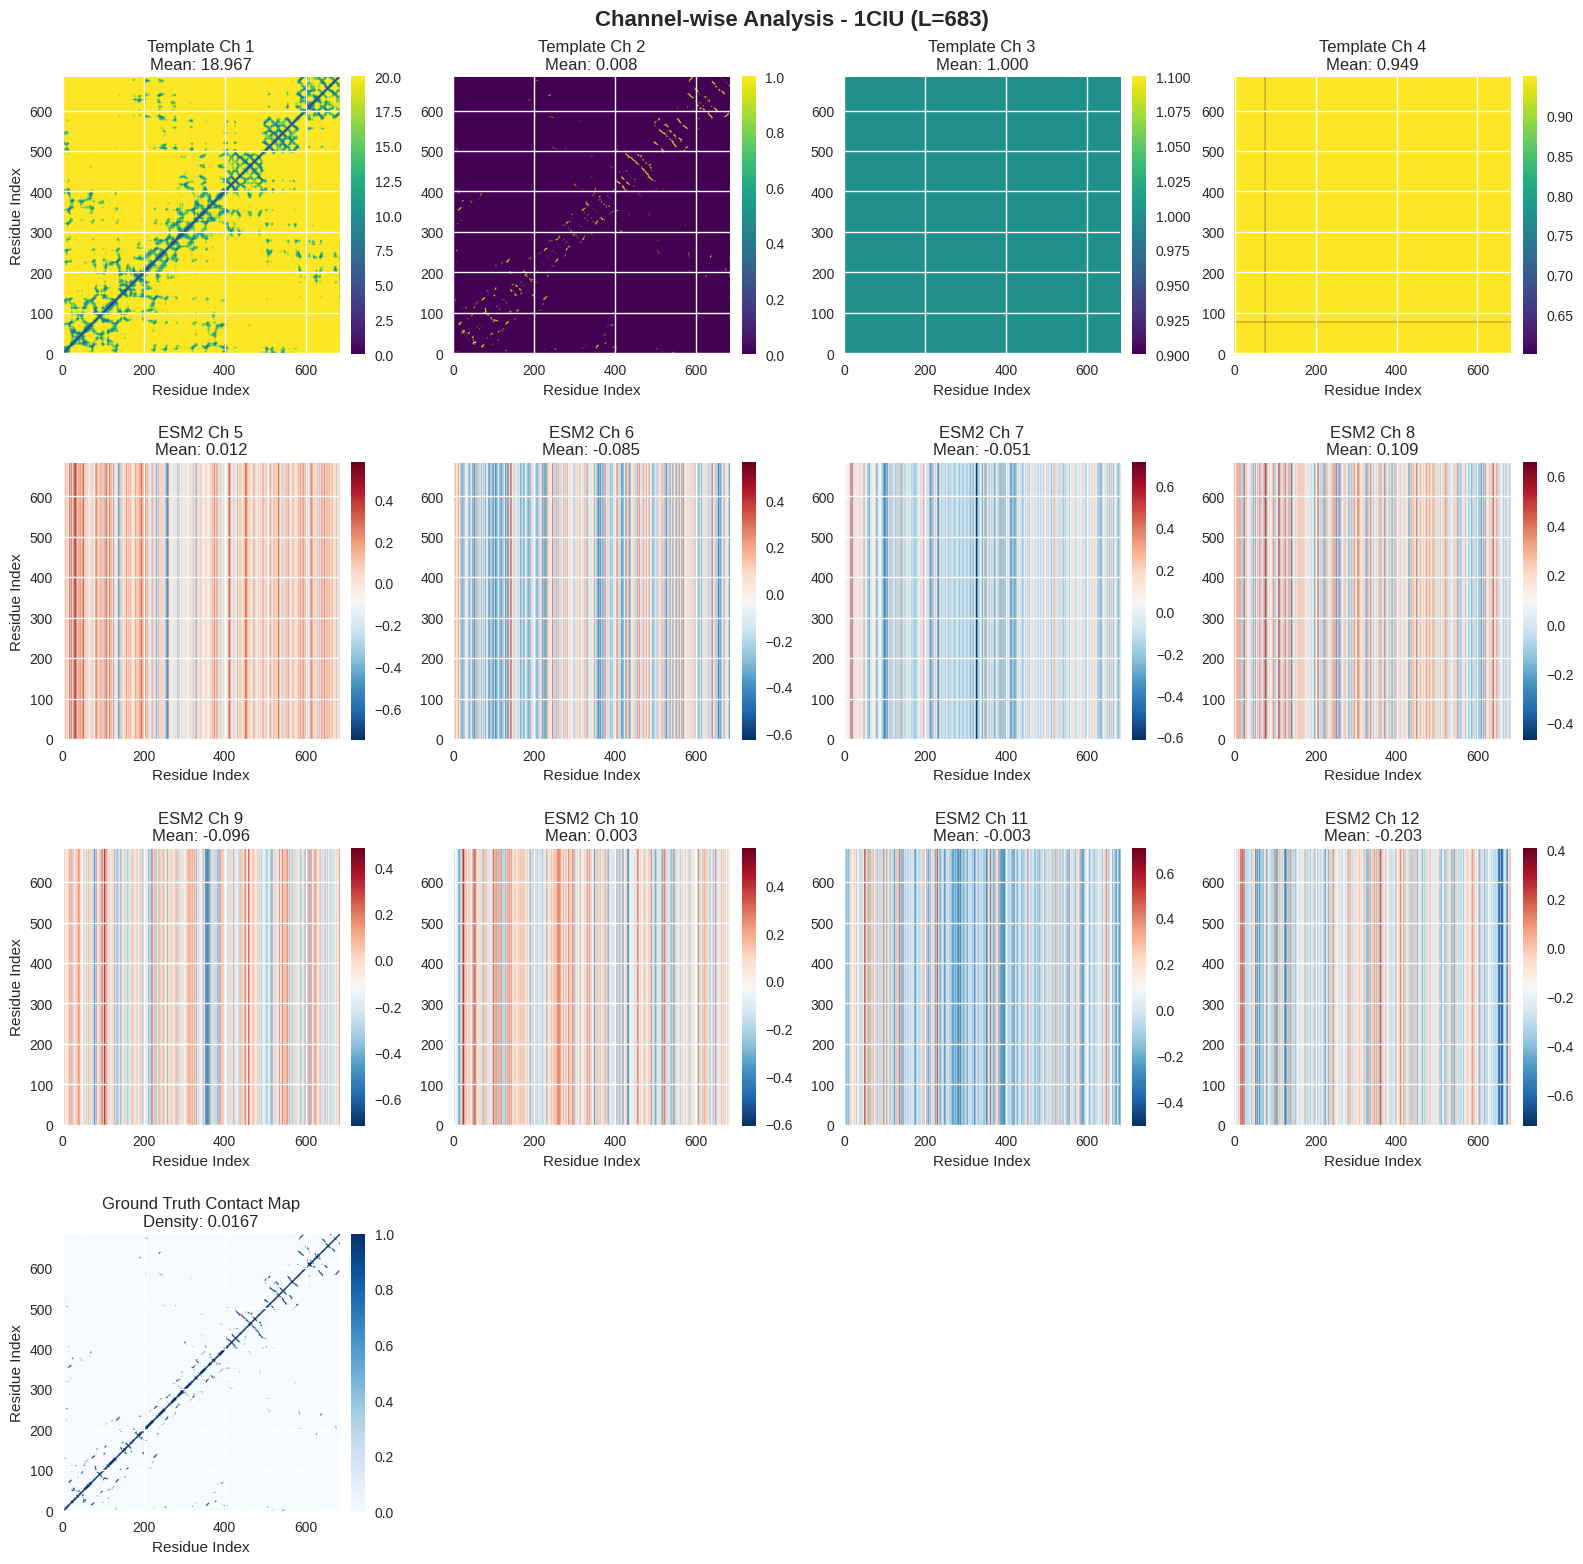


📊 Channel Statistics for 1CIU:
   Channel      Mean     Std      Range           Type      
   ------------ -------- -------- --------------- ----------
   Ch 1   18.967   2.856    [0.00, 20.00] Template  
   Ch 2   0.008    0.087    [0.00, 1.00] Template  
   Ch 3   1.000    0.000    [1.00, 1.00] Template  
   Ch 4   0.949    0.019    [0.60, 0.95] Template  
   Ch 5   0.012    0.171    [-0.75, 0.58] ESM2      
   Ch 6   -0.085   0.192    [-0.63, 0.56] ESM2      
   Ch 7   -0.051   0.167    [-0.61, 0.71] ESM2      
   Ch 8   0.109    0.175    [-0.47, 0.66] ESM2      
   Ch 9   -0.096   0.172    [-0.72, 0.49] ESM2      
   Ch 10  0.003    0.168    [-0.61, 0.56] ESM2      
   Ch 11  -0.003   0.186    [-0.51, 0.71] ESM2      
   Ch 12  -0.203   0.173    [-0.73, 0.41] ESM2      

🎨 Visualizing channels for 1CVF
   Tensor shape: (68, 255, 255)
   Showing first 12 channels


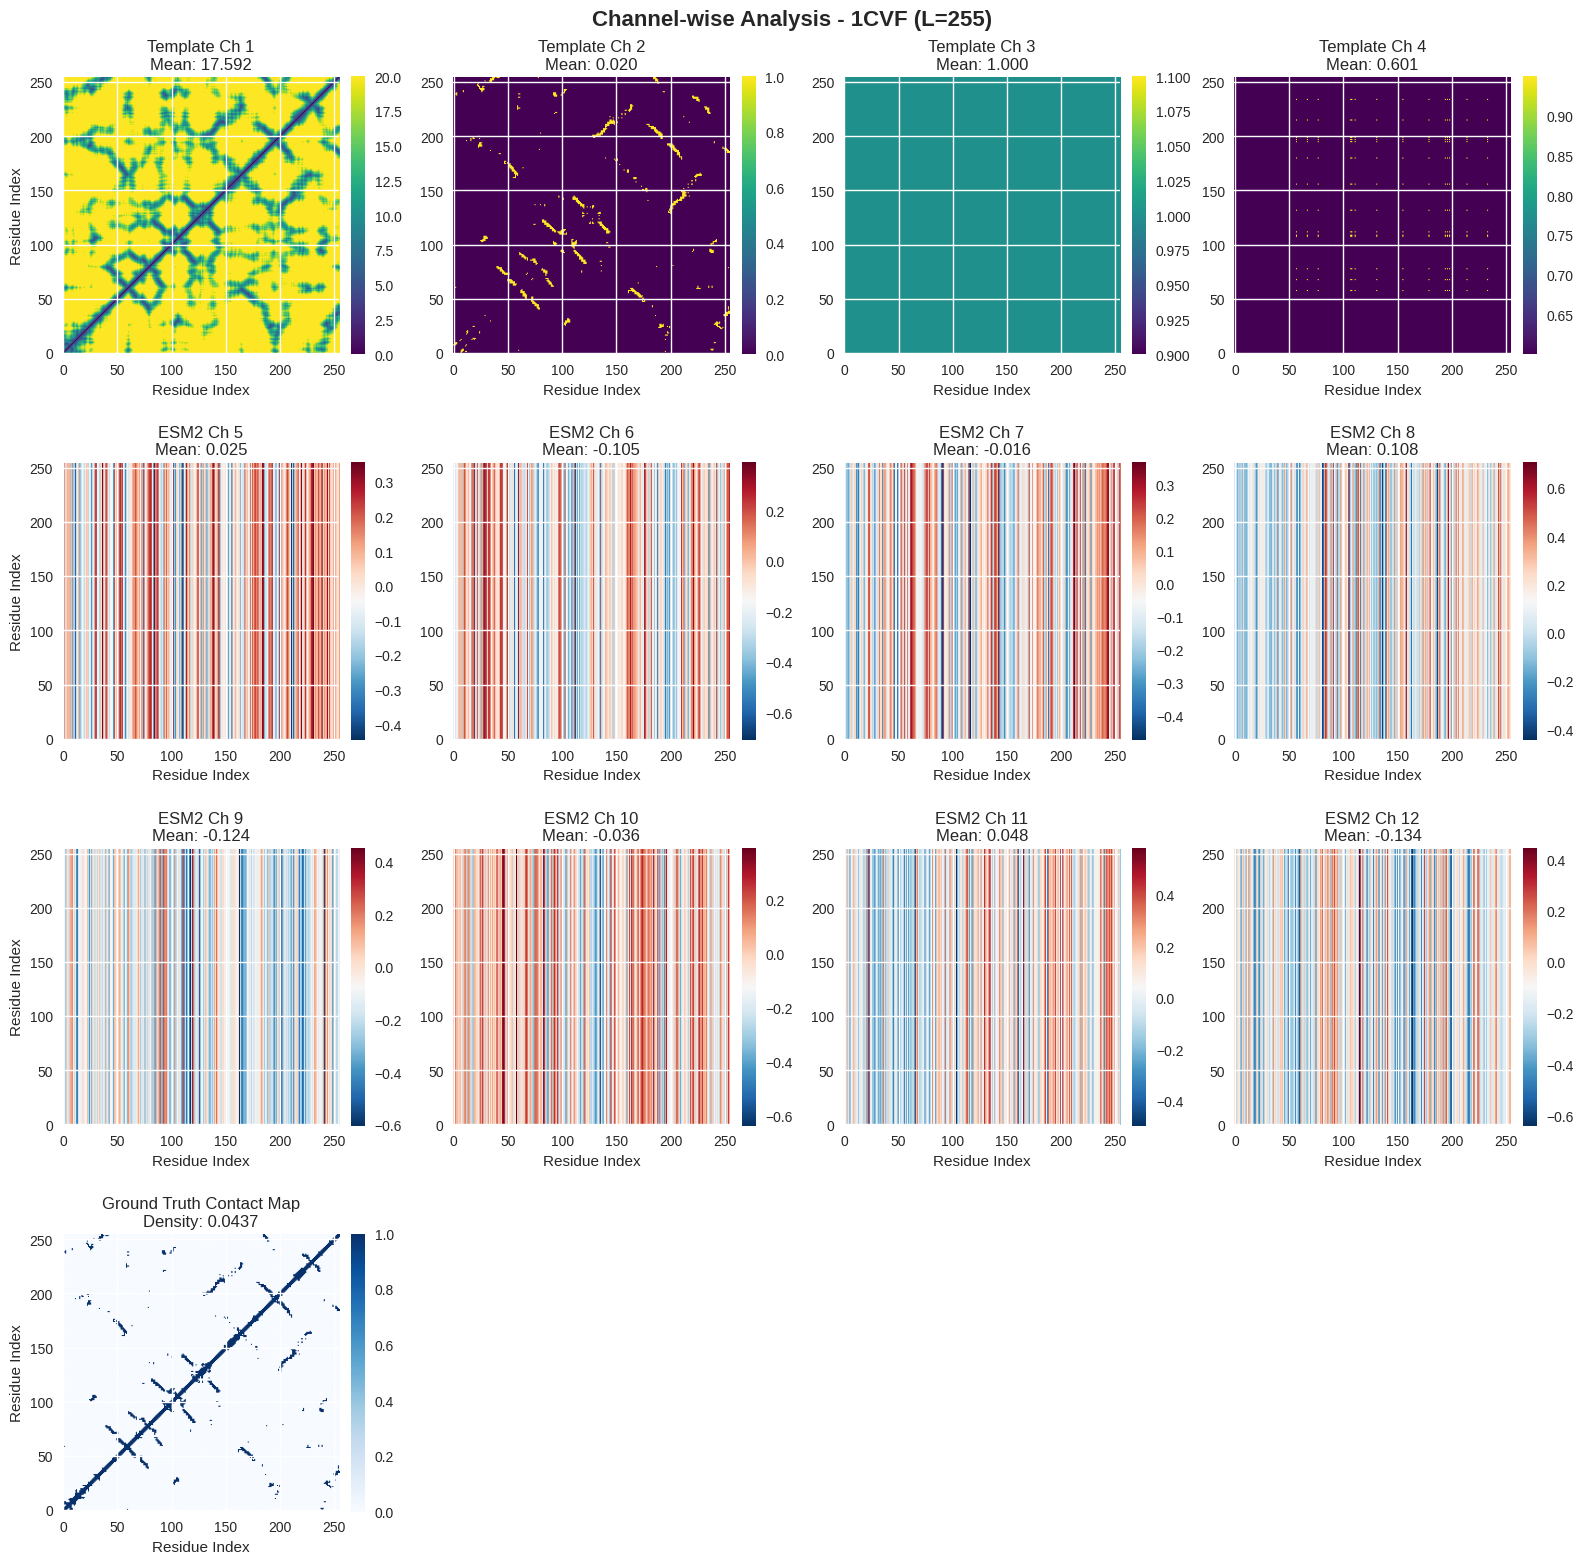


📊 Channel Statistics for 1CVF:
   Channel      Mean     Std      Range           Type      
   ------------ -------- -------- --------------- ----------
   Ch 1   17.592   4.071    [0.00, 20.00] Template  
   Ch 2   0.020    0.141    [0.00, 1.00] Template  
   Ch 3   1.000    0.000    [1.00, 1.00] Template  
   Ch 4   0.601    0.019    [0.60, 0.95] Template  
   Ch 5   0.025    0.164    [-0.45, 0.36] ESM2      
   Ch 6   -0.105   0.205    [-0.71, 0.39] ESM2      
   Ch 7   -0.016   0.167    [-0.47, 0.37] ESM2      
   Ch 8   0.108    0.200    [-0.45, 0.71] ESM2      
   Ch 9   -0.124   0.174    [-0.60, 0.45] ESM2      
   Ch 10  -0.036   0.185    [-0.64, 0.39] ESM2      
   Ch 11  0.048    0.195    [-0.50, 0.58] ESM2      
   Ch 12  -0.134   0.192    [-0.64, 0.45] ESM2      
🔒 Dataset closed


In [4]:
# Visualize channels for sample proteins
if protein_analyses:
    for protein_id in list(protein_analyses.keys())[:2]:  # Analyze first 2 proteins
        visualize_channels(protein_analyses[protein_id], protein_id, max_channels=12)
else:
        print("❌ No protein data available for visualization")

# Close dataset when done
if hdf5_file:
    hdf5_file.close()
    print("🔒 Dataset closed")